In [ ]:
# import needed library
import re
from collections import defaultdict
import getpass
import pandas as pd
import random
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import numpy as np
import os
import seaborn as sns

# import spark library
import pyspark
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.functions import col, count, countDistinct, max
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import sum as spark_sum, expr, percentile_approx, array, lit
from pyspark.sql.window import Window
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import RankingEvaluator

In [47]:
# Define some helper functions to make working with Spark easier
def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [48]:
start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=2)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.ui.port,4736
spark.executor.memory,4g
spark.sql.warehouse.dir,file:/users/home/ywa286/spark-warehouse
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.app.startTime,1729538406429
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32


## Q1: Taste Data Exploration

### (a, b)

In [93]:
total_cores = spark.sparkContext.defaultParallelism
print(f"Total number of cores: {total_cores}")

Total number of cores: 4


In [75]:
# Load the task data by infer schema mode
taste_df = spark.read.format("csv") \
    .option("sep", "\t") \
    .option("header", "false") \
    .option("inferSchema", "true") \
    .load("hdfs:///data/msd/tasteprofile/triplets.tsv") \
    .toDF("user_id", "song_id", "play_count")

In [94]:
# get current number of partitions
num_partitions = taste_df.rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

Number of partitions: 4


In [98]:
# repartition the dataframe
taste_df = taste_df.repartition(8)
taste_df.cache()
taste_df.count()
num_partitions = taste_df.rdd.getNumPartitions()
print(f"Number of partitions: {num_partitions}")

Number of partitions: 8


In [6]:
# Calculate unique songs and users
unique_songs = taste_df.select("song_id").distinct().count()
unique_users = taste_df.select("user_id").distinct().count()

print(f"Number of unique songs: {unique_songs}")
print(f"Number of unique users: {unique_users}")

# Find the number of unique songs played by the most active user
most_active_user_songs = taste_df.groupBy("user_id").agg(countDistinct("song_id").alias("unique_songs")) \
    .agg(max("unique_songs").alias("max_unique_songs")).collect()[0]["max_unique_songs"]

print(f"Number of unique songs played by the most active user: {most_active_user_songs}")
print(f"Percentage of total unique songs: {most_active_user_songs / unique_songs * 100:.2f}%")

Number of unique songs: 384546
Number of unique users: 1019318
Number of unique songs played by the most active user: 4400
Percentage of total unique songs: 1.14%


In [26]:
# scope
TrackNum = taste_df.select('song_id').distinct().count()
UserNum = taste_df.select('user_id').distinct().count()
print(f'TrackNum: {TrackNum}; UserNum: {UserNum}')

df_user = (
    taste_df
    .groupBy('user_id')
    .agg(
        F.sum(F.col('play_count')).alias('TotalCount')
    )
)

# the most active user
active_id = (df_user
    .orderBy(F.desc('TotalCount'))
    .limit(1)
).collect()[0]['user_id']

unique_songs = (
    taste_df
    .filter(F.col('user_id') == active_id)
    .select('song_id')
    .distinct()
    .count()
)

print(f'The most active user is {active_id}, played {unique_songs} unique songs, which is {unique_songs/TrackNum * 100}% of the total songs.')

TrackNum: 384546; UserNum: 1019318
The most active user is 093cb74eb3c517c5179ae24caf0ebec51b24d2a2, played 202 unique songs, which is 0.05252947631752768% of the total songs.


### (c, d)

In [7]:
# Calculate total play count
total_plays = taste_df.agg({"play_count": "sum"}).collect()[0][0]

# Calculate average plays per user
avg_plays_per_user = taste_df.groupBy("user_id").agg({"play_count": "sum"}) \
    .agg({"sum(play_count)": "avg"}).collect()[0][0]

# Calculate average plays per song
avg_plays_per_song = taste_df.groupBy("song_id").agg({"play_count": "sum"}) \
    .agg({"sum(play_count)": "avg"}).collect()[0][0]

print(f"Total play count: {total_plays}")
print(f"Average plays per user: {avg_plays_per_user:.2f}")
print(f"Average plays per song: {avg_plays_per_song:.2f}")


Total play count: 138680243
Average plays per user: 136.05
Average plays per song: 360.63


In [4]:
# Calculate basic statistics and percentiles
stats = taste_df.select("play_count").summary("count", "mean", "stddev", "min", "max")
percentiles = taste_df.select(
    percentile_approx("play_count", [0.25, 0.5, 0.75], 10000).alias("percentiles")
)

# Combine the results
result = stats.union(
    percentiles.select(
        expr("'25%' as summary"),
        expr("percentiles[0] as play_count")
    )
).union(
    percentiles.select(
        expr("'50%' as summary"),
        expr("percentiles[1] as play_count")
    )
).union(
    percentiles.select(
        expr("'75%' as summary"),
        expr("percentiles[2] as play_count")
    )
)

# Show the results
show_as_html(result)



,summary,play_count
0,count,48373586
1,mean,2.866858847305635
2,stddev,6.437724686877004
3,min,1
4,max,9667
5,25%,1
6,50%,1
7,75%,3


In [11]:
# Calculate total play count per user
user_play_count = taste_df.groupBy("user_id").agg(spark_sum("play_count").alias("total_play_count"))

# Calculate total play count per song
song_play_count = taste_df.groupBy("song_id").agg(spark_sum("play_count").alias("total_play_count"))

# Function to generate extended summary statistics
def extended_summary(df, col_name):
    basic_stats = df.select(col(col_name).cast(DoubleType())).summary("count", "mean", "stddev", "min", "max").collect()
    percentiles = df.select(
        percentile_approx(col(col_name).cast(DoubleType()), array(lit(0.25), lit(0.5), lit(0.75)), 10000).alias("percentiles")
    ).first()["percentiles"]
    
    iqr = percentiles[2] - percentiles[0]
    
    # Define schema for the result DataFrame
    schema = StructType([
        StructField("summary", StringType(), True),
        StructField(col_name, DoubleType(), True)
    ])
    
    return spark.createDataFrame([
        ("count", float(basic_stats[0][1])),
        ("mean", float(basic_stats[1][1])),
        ("stddev", float(basic_stats[2][1])),
        ("min", float(basic_stats[3][1])),
        ("25%", float(percentiles[0])),
        ("50% (median)", float(percentiles[1])),
        ("75%", float(percentiles[2])),
        ("max", float(basic_stats[4][1])),
        ("IQR", float(iqr))
    ], schema)

# Generate and display extended summary statistics for user play counts
print("Extended summary statistics for total play count per user:")
extended_summary(user_play_count, "total_play_count").show()

# Generate and display extended summary statistics for song play counts
print("Extended summary statistics for total play count per song:")
extended_summary(song_play_count, "total_play_count").show()

,user_id,total_play_count
0,7756f32a3154f5ed0740f0c2d470e21a9368638c,862
1,9a0bc3438c742a2d9e122d856304036e239d1603,12
2,cfdf491ab02f94cb7ecb1f350492ad067a382145,144
3,2804bef281dabd3ed7a1dff17283b0a698ccd977,262
4,e5d8438c919230648f7efb9d25c3d049dba2e601,527
5,871a00d032da42348acb5772479882af155c108d,226
6,0ed36ff571e2b44ee2ed5586a60690f512eba243,17
7,cf5352c12ae1faa19dc032d0cf2a234db1bd230d,254
8,ee7e96b4093c2d38162d9f63940d46823651c019,445
9,59bbb4279e5f0393344985ff2d3f9251b2f39c0a,740


Extended summary statistics for total play count per user:
+------------+------------------+
|     summary|  total_play_count|
+------------+------------------+
|       count|         1019318.0|
|        mean| 136.0519906447252|
|      stddev|184.52548802802616|
|         min|              10.0|
|         25%|              34.0|
|50% (median)|              73.0|
|         75%|             163.0|
|         max|           13132.0|
|         IQR|             129.0|
+------------+------------------+

Extended summary statistics for total play count per song:
+------------+------------------+
|     summary|  total_play_count|
+------------+------------------+
|       count|          384546.0|
|        mean|360.63369011769726|
|      stddev| 3256.809395023515|
|         min|               1.0|
|         25%|               8.0|
|50% (median)|              32.0|
|         75%|             133.0|
|         max|          726885.0|
|         IQR|             125.0|
+------------+-----------------

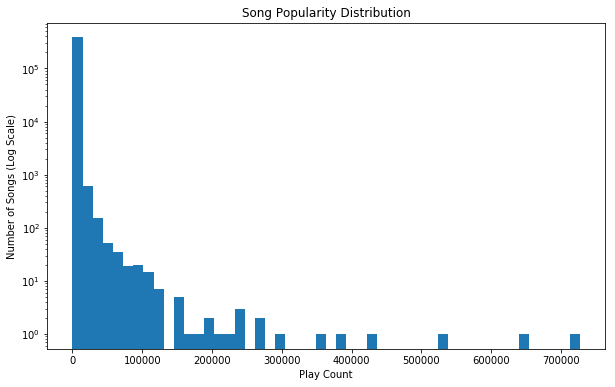

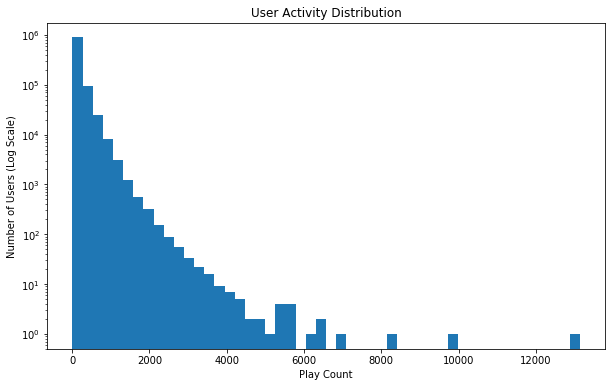

In [15]:
# visualise the distribution of play counts for songs and users
# Collect song popularity data (limited to top 10000 most popular songs)
song_popularity = taste_df.groupBy("song_id").agg(spark_sum("play_count").alias("total_plays")) \
    .orderBy(col("total_plays").desc()) \
    .toPandas()

# Collect user activity data (limited to top 10000 most active users)
user_activity = taste_df.groupBy("user_id").agg(spark_sum("play_count").alias("total_plays")) \
    .orderBy(col("total_plays").desc()) \
    .toPandas()
# Create song popularity distribution plot
plt.figure(figsize=(10, 6))
plt.hist(song_popularity['total_plays'], bins=50, log=True)
plt.title('Song Popularity Distribution')
plt.xlabel('Play Count')
plt.ylabel('Number of Songs (Log Scale)')
plt.show()

# Create user activity distribution plot
plt.figure(figsize=(10, 6))
plt.hist(user_activity['total_plays'], bins=50, log=True)
plt.title('User Activity Distribution')
plt.xlabel('Play Count')
plt.ylabel('Number of Users (Log Scale)')
plt.show()

## Q2: Collaborative Filtering

## (a)

In [53]:
# Step 1: Remove songs that have been played fewer than N times
N = 8  # You can adjust this value as needed
song_plays = taste_df.groupBy("song_id").agg(F.sum("play_count").alias("total_plays"))
popular_songs = song_plays.filter(F.col("total_plays") >= N).select("song_id")
df_filtered_songs = taste_df.join(popular_songs, on="song_id")

# Step 2: Remove users who have listened to fewer than M songs
M = 34  # You can adjust this value as needed
user_song_counts = df_filtered_songs.groupBy("user_id").agg(F.sum("play_count").alias("total_plays"))
active_users = user_song_counts.filter(F.col("total_plays") >= M).select("user_id")
final_df = df_filtered_songs.join(active_users, on="user_id")

# Step 3: Recalculate the number of songs each user has listened to and reapply the M filter
user_song_counts_updated = final_df.groupBy("user_id").agg(F.sum("play_count").alias("total_plays"))
active_users_updated = user_song_counts_updated.filter(F.col("total_plays") >= M).select("user_id")
final_df = final_df.join(active_users_updated, on="user_id")

# Calculate statistics before and after filtering
initial_users = taste_df.select("user_id").distinct().count()
initial_songs = taste_df.select("song_id").distinct().count()

final_users = final_df.select("user_id").distinct().count()
final_songs = final_df.select("song_id").distinct().count()

excluded_users = initial_users - final_users
excluded_songs = initial_songs - final_songs

# Print results
print(f"Initial users: {initial_users}")
print(f"Initial songs: {initial_songs}")
print(f"Remaining users: {final_users}")
print(f"Remaining songs: {final_songs}")
print(f"Excluded users: {excluded_users}")
print(f"Excluded songs: {excluded_songs}")
print(f"Percentage of users excluded: {excluded_users/initial_users*100:.2f}%")
print(f"Percentage of songs excluded: {excluded_songs/initial_songs*100:.2f}%")

Initial users: 1019318
Initial songs: 384546
Remaining users: 763650
Remaining songs: 292884
Excluded users: 255668
Excluded songs: 91662
Percentage of users excluded: 25.08%
Percentage of songs excluded: 23.84%


### (b)

In [ ]:
# Create StringIndexers for user_id and song_id
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
song_indexer = StringIndexer(inputCol="song_id", outputCol="song_index")

# Fit the indexers on the data
user_model = user_indexer.fit(final_df)
song_model = song_indexer.fit(final_df)

# Transform the dataframe
indexed_df = user_model.transform(final_df)
indexed_df = song_model.transform(indexed_df)

# Select the columns we need
taste_df = indexed_df.select(
    col("user_index").cast("int").alias("user"),
    col("song_index").cast("int").alias("song"),
    "play_count"
)

### (c)

In [55]:
# split the data into training and test sets
# Step 1: Assign a random number to each row
df_with_random = taste_df.withColumn("rand", F.rand())

# Step 2: For each user, rank their plays by the random number
window = Window.partitionBy("user").orderBy("rand")
df_ranked = df_with_random.withColumn("rank", F.rank().over(window))

# Step 3: Calculate the number of plays for each user
df_with_count = df_ranked.withColumn("user_play_count", F.count("user").over(Window.partitionBy("user")))

# Step 4: Determine the split point for each user (80% for training)
df_with_split = df_with_count.withColumn("split_point", (F.col("user_play_count") * 0.8).cast("int"))

# Step 5: Create the train and test sets
train_df = df_with_split.filter(F.col("rank") <= F.col("split_point")).drop("rand", "rank", "user_play_count", "split_point")
test_df = df_with_split.filter(F.col("rank") > F.col("split_point")).drop("rand", "rank", "user_play_count", "split_point")

# Print some statistics
print(f"Training set size: {train_df.count()}")
print(f"Test set size: {test_df.count()}")
print(f"Number of users in training set: {train_df.select('user').distinct().count()}")
print(f"Number of users in test set: {test_df.select('user').distinct().count()}")

Training set size: 35138655
Test set size: 9166417
Number of users in training set: 763650
Number of users in test set: 763650


### (d)

In [59]:
# Convert play_count to implicit feedback
# We'll treat any play_count > 0 as implicit positive feedback
train_df = train_df.withColumn("implicit_feedback", (col("play_count") > 0).cast("double"))
test_df = test_df.withColumn("implicit_feedback", (col("play_count") > 0).cast("double"))

# Initialize ALS model
als = ALS(
    maxIter=5,
    regParam=0.01,
    userCol="user",
    itemCol="song",
    ratingCol="implicit_feedback",
    coldStartStrategy="drop",
    implicitPrefs=True
)

# Fit the model to the training data
model = als.fit(train_df)

### (e)

In [89]:
# Select a few users from the test set
sample_users = test_df.select("user").distinct().limit(3).collect()
sample_user_ids = [row['user'] for row in sample_users]

# Generate recommendations for these users
num_recommendations = 10
user_recs = model.recommendForUserSubset(spark.createDataFrame([(uid,) for uid in sample_user_ids], ["user"]), num_recommendations)

# Get the actual songs played by these users
user_actual_songs = test_df.filter(test_df.user.isin(sample_user_ids)).groupBy("user").agg(F.collect_list("song").alias("actual_songs"))

# Compare the recommendations with the actual songs played
comparison_results = user_recs.join(user_actual_songs, "user")

# Display the results
comparison_results.show(truncate=False)

+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [90]:
# Detailed analysis for each user
for row in comparison_results.collect():
    user_id = row['user']
    recommended_songs = [rec['song'] for rec in row['recommendations']]
    actual_songs = row['actual_songs']
    
    print(f"\nUser ID: {user_id}")
    print(f"Top 10 Recommended Songs: {recommended_songs}")
    print(f"Actual Songs Played: {actual_songs[:10]} ... (showing first 10)")
    
    # Calculate how many of the recommendations were actually played by the user
    hits = set(recommended_songs) & set(actual_songs)
    precision = len(hits) / len(recommended_songs)
    
    print(f"Precision@10: {precision:.2f}")
    print(f"Number of correct recommendations: {len(hits)}")

# Calculate overall precision
total_hits = sum(len(set(row['recommendations']) & set(row['actual_songs'])) for row in comparison_results.collect())
total_recommendations = sum(len(row['recommendations']) for row in comparison_results.collect())
overall_precision = total_hits / total_recommendations

print(f"\nOverall Precision@10: {overall_precision:.2f}")


User ID: 12
Top 10 Recommended Songs: [27, 106, 159, 13, 158, 235, 204, 242, 81, 58]
Actual Songs Played: [26293, 6680, 17163, 100022, 39212, 17940, 699, 7378, 16881, 1583] ... (showing first 10)
Precision@10: 0.10
Number of correct recommendations: 1

User ID: 18
Top 10 Recommended Songs: [23, 17, 14, 125, 109, 114, 128, 132, 38, 16]
Actual Songs Played: [9257, 8538, 20318, 14462, 45888, 38002, 39472, 91, 128, 1516] ... (showing first 10)
Precision@10: 0.20
Number of correct recommendations: 2

User ID: 38
Top 10 Recommended Songs: [4, 61, 44, 54, 136, 204, 6, 170, 26, 242]
Actual Songs Played: [6418, 9426, 39665, 70688, 13583, 23675, 58364, 10022, 1188, 23617] ... (showing first 10)
Precision@10: 0.00
Number of correct recommendations: 0

Overall Precision@10: 0.00


### (f)

In [86]:
# make predictions on the test set
predictions = model.transform(test_df)
predictions.cache()

# generate recommendations for all users
recommendations = model.recommendForAllUsers(10)

# Collect and sort relevant items from test in order of descending relevance (e.g. rating)
relevant = (
    test_df
    .groupBy("user")
    .agg(
        F.reverse(F.sort_array(F.collect_list(
            F.struct(
                F.col("implicit_feedback").alias("rating"),
                F.col("song"),
            )
        ))).alias("relevant")
    )
)
relevant.printSchema()

# Merge recommendations and relevant items so they can be compared
temp = (
    recommendations.select(
        F.col("user"),
        F.col("recommendations.song").alias("recommendations").astype(ArrayType(DoubleType())),
    )
    .join(
        relevant.select(
            F.col("user"),
            F.col("relevant.song").alias("relevant").astype(ArrayType(DoubleType())),
        ),
        on="user",
        how="inner"
    )
)
temp.cache()

temp.printSchema()
show_as_html(temp)

root
 |-- user: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- relevant: array (nullable = false)
 |    |-- element: double (containsNull = true)



,user,recommendations,relevant
0,12,"[27.0, 106.0, 159.0, 13.0, 158.0, 235.0, 204.0...","[228154.0, 224136.0, 212507.0, 211192.0, 20125..."
1,18,"[23.0, 17.0, 14.0, 125.0, 109.0, 114.0, 128.0,...","[269795.0, 245159.0, 233362.0, 195067.0, 18483..."
2,38,"[4.0, 61.0, 44.0, 54.0, 136.0, 204.0, 6.0, 170...","[228355.0, 216961.0, 205085.0, 171948.0, 12252..."
3,70,"[61.0, 170.0, 370.0, 27.0, 56.0, 511.0, 311.0,...","[272918.0, 266349.0, 216555.0, 199435.0, 19528..."
4,93,"[23.0, 17.0, 14.0, 109.0, 125.0, 16.0, 9.0, 11...","[224969.0, 189336.0, 186048.0, 175744.0, 17561..."
5,190,"[54.0, 44.0, 26.0, 16.0, 27.0, 159.0, 32.0, 40...","[270820.0, 257363.0, 252783.0, 241393.0, 23044..."
6,218,"[61.0, 170.0, 370.0, 511.0, 539.0, 311.0, 477....","[273613.0, 265116.0, 235679.0, 209911.0, 19892..."
7,273,"[27.0, 106.0, 13.0, 36.0, 80.0, 369.0, 1180.0,...","[281046.0, 242372.0, 232445.0, 225431.0, 20987..."
8,300,"[1.0, 0.0, 61.0, 47.0, 56.0, 57.0, 113.0, 9.0,...","[214557.0, 166863.0, 124754.0, 119832.0, 11219..."
9,340,"[1.0, 0.0, 61.0, 57.0, 47.0, 56.0, 27.0, 25.0,...","[254009.0, 225489.0, 198477.0, 182625.0, 17639..."


In [88]:
# Evaluate the model using RankingEvaluator
evaluator = RankingEvaluator(predictionCol="recommendations", labelCol="relevant")

precisionAtK = evaluator.evaluate(temp, {evaluator.metricName: "precisionAtK",            evaluator.k: 10})
mapAtK       = evaluator.evaluate(temp, {evaluator.metricName: "meanAveragePrecisionAtK", evaluator.k: 10})
ndcgAtK      = evaluator.evaluate(temp, {evaluator.metricName: "ndcgAtK",                 evaluator.k: 10})

print(f'metrics for implicit feedback')
print(f'')
print(f'precision @ K: {precisionAtK:.5f}')
print(f'MAP @ K:       {mapAtK:.5f}')
print(f'NDCG @ K:      {ndcgAtK:.5f}')
print(f'')

metrics for implicit feedback

precision @ K: 0.04018
MAP @ K:       0.02550
NDCG @ K:      0.05708



In [92]:
stop_spark()